In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.data import get_data
from src.util import common

from src.features.build_features import series_to_supervised

import pickle

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [110]:
df = df = pd.read_csv('../data/raw/data.csv', index_col=0)
df = df[['timestamp','open','high','close','low','volumeto', 'volumefrom']]

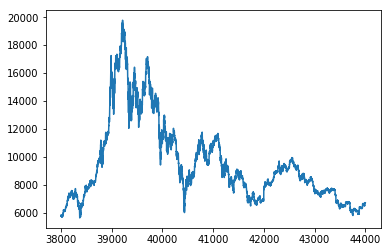

In [111]:
TRAIN_DATA_START_HOUR_INDEX = 38000
df=df.iloc[TRAIN_DATA_START_HOUR_INDEX:,:]
plt.plot(df.close)

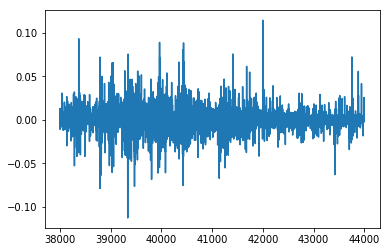

In [112]:
df['percent_change']=df.close.pct_change()
df.head()
plt.plot(df.percent_change)

In [113]:
MAS = [6, 12,24,48]
for MA in MAS:
    df['vt_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
    df['vf_ma' + str(MA)] = df.volumefrom.rolling(MA).mean()
# df.drop(['volumefrom', 'volumeto'], axis=1, inplace=True)
df.head()

,timestamp,open,high,close,low,volumeto,volumefrom,percent_change,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48
38000,2017-10-27 21:00:00,5720.81,5771.76,5746.76,5718.96,16627196.53,2890.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38001,2017-10-27 22:00:00,5746.75,5750.77,5748.69,5708.47,13858838.31,2414.91,0.000336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38002,2017-10-27 23:00:00,5748.58,5788.10,5747.98,5744.09,14572098.03,2523.99,-0.000124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38003,2017-10-28 00:00:00,5747.85,5779.01,5779.01,5736.39,13103265.76,2273.05,0.005398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38004,2017-10-28 01:00:00,5778.62,5783.08,5764.56,5737.18,7501329.72,1301.45,-0.002500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


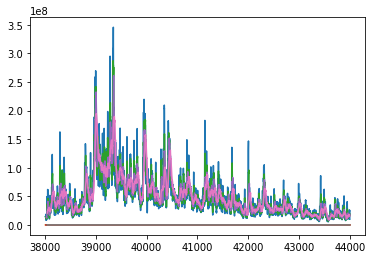

In [114]:
plt.plot(df.filter(regex='v(t|f)'))

In [115]:
df = df.drop(['timestamp'], axis=1)\
    .dropna(how='any', axis=0)

df.head()

,open,high,close,low,volumeto,volumefrom,percent_change,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48
38047,5950.56,5983.36,5971.60,5878.16,1.388547e+07,2325.90,0.003534,3.022768e+07,5095.088333,2.996392e+07,5104.167500,2.810384e+07,4841.692500,2.081600e+07,3598.620000
38048,5971.60,6128.76,6128.39,5966.00,6.591457e+07,10887.14,0.026256,3.854662e+07,6447.608333,3.018135e+07,5105.160833,3.021255e+07,5184.726250,2.184282e+07,3765.210208
38049,6129.08,6295.43,6194.25,6110.79,1.521622e+08,24487.18,0.010747,6.198330e+07,10197.246667,3.983274e+07,6623.656667,3.606819e+07,6120.765000,2.472414e+07,4225.049167
38050,6196.32,6232.10,6194.67,6140.23,5.457368e+07,8826.87,0.000068,5.993974e+07,9792.996667,4.364792e+07,7232.626667,3.799662e+07,6428.232500,2.555750e+07,4356.359167
38051,6193.96,6197.33,6181.02,6130.72,3.756716e+07,6094.29,-0.002204,5.799544e+07,9436.018333,4.561178e+07,7538.645833,3.933351e+07,6642.435417,2.606717e+07,4435.968333


In [116]:
N_FEATURES = len(df.columns)
Tx = 72
Ty = 1
N_FEATURES

15

In [117]:
X = series_to_supervised(data=df, n_in=Tx, n_out=Ty)
Y = series_to_supervised(data=list(df['percent_change']), n_in=Tx, n_out=Ty)

In [118]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


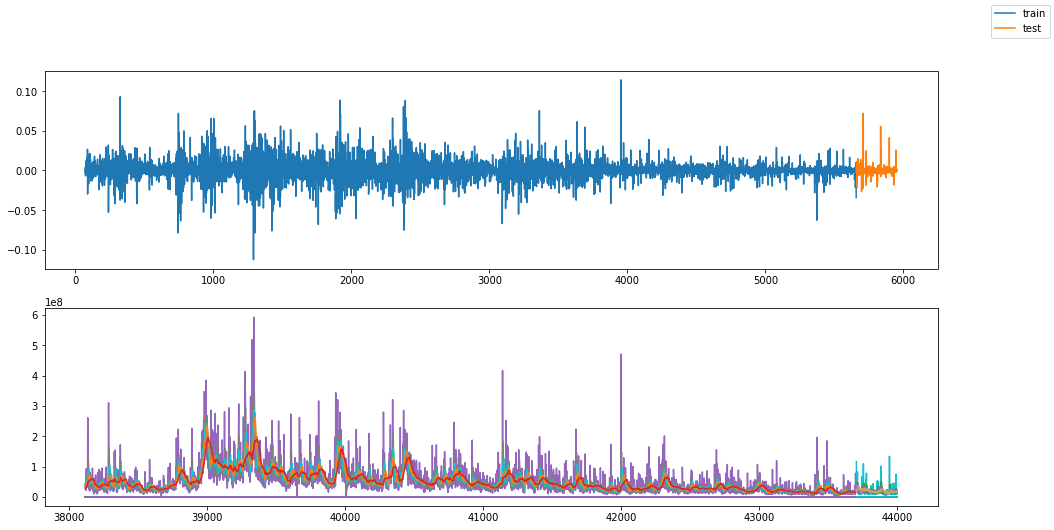

In [119]:
fig, ax = plt.subplots(2)
fig.set_size_inches(16,8)
ax[0].plot(Y_train, label='train')
ax[0].plot(Y_test, label='test')

ax[1].plot(X_train.iloc[:,-N_FEATURES:])
ax[1].plot(X_test.iloc[:,-N_FEATURES:])
fig.legend()

In [120]:
X_train.to_csv('../data/processed/X_train.csv',index=False)
X_test.to_csv('../data/processed/X_test.csv',index=False)
Y_train.to_csv('../data/processed/Y_train.csv',index=False)
Y_test.to_csv('../data/processed/Y_test.csv',index=False)